# Bitcoin Price Prediction 
## Gohur Ali, Matthew Rodriguez

In this notebook we prototype some deep learning models built in PyTorch to discover patterns to aid in the prediction of various trends in Bitcoin. Overall, we hope that it helps us in our personal investments.

We employ the use of multilayer perceptrons for volume and price prediction.

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')
import requests
import os
import yaml
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import urllib3
import cryptocompare
from datetime import datetime

In [2]:
print("PyTorch version:", torch.__version__)

PyTorch version: 1.0.1.post2


{'TimeFrom': 1439683200, 'Type': 100, 'RateLimit': {}, 'Aggregated': False, 'TimeTo': 1564099200, 'HasWarning': False, 'FirstValueInArray': True, 'Response': 'Success', 'Data': [{'low': 254.57, 'volumeto': 17880398.95, 'open': 260.52, 'close': 257.12, 'high': 261.92, 'time': 1439683200, 'volumefrom': 69037.08}, {'low': 252.87, 'volumeto': 12378054.89, 'open': 257.12, 'close': 257.13, 'high': 259.93, 'time': 1439769600, 'volumefrom': 47882.96}, {'low': 245.74, 'volumeto': 23896056.77, 'open': 257.13, 'close': 246.72, 'high': 257.53, 'time': 1439856000, 'volumefrom': 94503.04}, {'low': 214.29, 'volumeto': 55514712.14, 'open': 246.72, 'close': 226, 'high': 247.95, 'time': 1439942400, 'volumefrom': 245822.71}, {'low': 225.54, 'volumeto': 21225055.42, 'open': 226, 'close': 234.66, 'high': 238.03, 'time': 1440028800, 'volumefrom': 90981.27}, {'low': 230.48, 'volumeto': 13485729.48, 'open': 234.66, 'close': 232.4, 'high': 236.3, 'time': 1440115200, 'volumefrom': 57649.08}, {'low': 221.04, 'vo

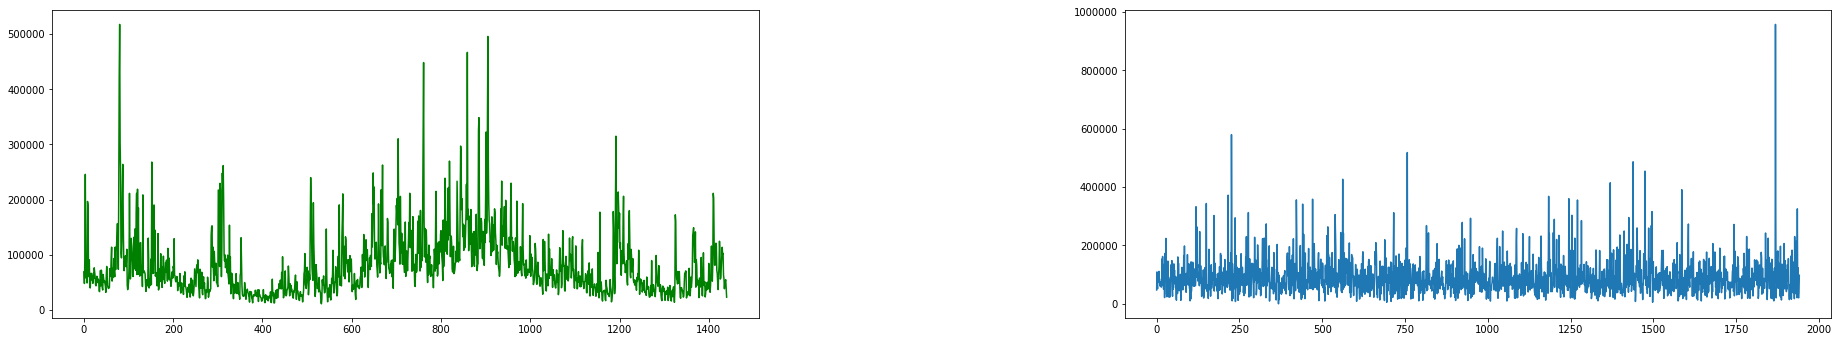

In [3]:
# hourly -- volume -- per day
# USD 

#cryptocompare api key:1 e3c9fe62074dbf5805d45f528d1e60c7ae15be68a63ba57ca3a5f2f9dbbf66f

#close,high,low,open,time,volumefrom,volumeto

def posix2Human(time_):
    timestamp = time_
    dt_object = datetime.fromtimestamp(timestamp)
    return dt_object

histPriceDay = cryptocompare.get_historical_price_day('BTC', curr='USD')
print((histPriceDay))

# Getting CryptoCompare BTC volume data -- 2000 API calls back 
vol = []
for idx, item in enumerate(histPriceDay['Data']):
    vol.append(item['volumefrom'])    

# -- Init subplots --
f,arr = plt.subplots(1,2)
  
arr[0].plot(np.array(vol),'g')

def fetch_latest_BTC_JSON():
    """Fetch the latest JSON data"""
    API_LINK = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=USD&apikey=SAITMI5ZUMGEKGKY'
    page = requests.get(API_LINK).json()
    return page

page = fetch_latest_BTC_JSON()

vol2 = []
for key,value in page['Time Series (Digital Currency Daily)'].items():
    vol2.append(float(value['5. volume']))
    
arr[1].plot(np.array(vol2))

plt.tight_layout()
f.set_figheight(5)
f.set_figwidth(30)

plt.show()

In [4]:
print('CryptoCompare last reported volume (yesterday): ', vol[-1])

CryptoCompare last reported volume (yesterday):  23113.43


In [5]:
def get_config(file_loc='../config.yaml'):
    return yaml.safe_load(open(file_loc))
config = get_config()
print(type(config))
print(config)

<class 'dict'>
{'mlp_learning_rate': 0.001, 'mlp_epochs': 50, 'mlp_batch_size': 1}


## Neural Net Architectures

In [6]:
"""
Basic multilayer perceptron subclass 
of three layers in PyTorch
"""
class MLP(nn.Module):
    def __init__(self,num_features):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(in_features=num_features,out_features=32)
        self.fc2 = nn.Linear(in_features=32,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=1)
    
    def forward(self, x):
        """"Forward pass definition"""
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x
      
class NumberRegression_MLP(nn.Module):
    def __init__(self):
        super(NumberRegression_MLP,self).__init__()
        self.fc1 = nn.Linear(in_features=1,out_features=32)
        self.fc2 = nn.Linear(in_features=32,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=1)
    def forward(self, x):
        """"Forward pass definition"""
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

"""
Recurrent Neural Networks (RNN)
RNNs are an excellent method to model sequential data
and time series data. This is perfect for stocks and
crytocurrency price prediction.
"""
class TestRNN(nn.Module):
    def __init__(self,input_dim,hidden_dim,layer_amnt):
        super(TestRNN,self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_amnt = layer_amnt
        
        self.lstm1 = nn.LSTM(input_size=self.input_dim,
                             hidden_size=self.hidden_dim,
                             num_layers=1,
                             bias=True,
                             batch_first=False,
                             dropout=0,
                             bidirectional=False
                            )
        self.fc1 = nn.Linear(in_features=150,out_features=256)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=32)
        self.fc4 = nn.Linear(in_features=32,out_features=1)
        
        pass
    def forward(self,x):
        pass

In [7]:
class TickerData(torch.utils.data.Dataset):
    def __init__(self, table):
        self.dataset = table
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        """idx --> data pointer"""
        return self.dataset[idx]

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [51]:
def fetch_latest_BTC_JSON():
    """Fetch the latest JSON data"""
    API_LINK = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=USD&apikey=SAITMI5ZUMGEKGKY'
    page = requests.get(API_LINK).json()
    return page
  
def fetch_btc_prices():
    with open("/content/gdrive/My Drive/College/Undergraduate Research/StockData/BTC_data.json") as f:
        return json.load(f)      
      
def parse_alphaV_JSON(raw_data):
    # Remove meta data for now
    raw_data.pop('Meta Data',None)
    # Remove key name
    df = pd.DataFrame.from_dict(raw_data['Time Series (Digital Currency Daily)'],dtype=float)
    # Flip dates as columns into rows
    df = df.transpose()
    return df

def normalize():
    pass
  
def data_split(x_train,y_train):
        x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=100,shuffle=False)
        return x_train, x_test, y_train, y_test

def train(model, x_data,y_data, original_prices):

    prices = torch.tensor(original_prices)
    max_price = torch.max(prices)
    min_price = torch.min(prices)

    print('----Dataset Prep----')
    x_train, x_test, y_train, y_test = data_split(x_data,y_data)
    train_tensorDataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
    train_data_loader = torch.utils.data.DataLoader(
        dataset=train_tensorDataset,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )

    test_tensorDataset = torch.utils.data.TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test))
    test_data_loader = torch.utils.data.DataLoader(
        dataset=test_tensorDataset,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )

    print('-- Model Architecture --')
    print(model)
    
    # -- Model to CUDA GPU --
    #model.to(device)

    # -- Since we are predicting prices --> mean squared error is our loss function
    loss_func = torch.nn.MSELoss()

    # -- Optimizer --> Adam generally works best
    # TODO: choose a better learning rate later
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    total_loss = 0
    losses = []
    for epoch in (range(50)):
        for i, (examples,labels) in tqdm(enumerate(train_data_loader)):

            #print(examples , " ----- " , labels)
            
            optimizer.zero_grad()
            
            # -- Input to CUDA --
            #examples = examples.to(device)
            #labels = labels.to(device)
            
            y_predictions = model(examples.float())
            loss = loss_func(y_predictions.float(),labels.float())

            total_loss += loss.data

            # back-prop to update the weights
            loss.backward()
            # optimizer steps based on lr
            optimizer.step()

            y_preds = y_predictions.cpu().detach().numpy()
            y_preds = torch.tensor(y_preds)
            #print(y_preds.shape)
            test = un_normalize(y_preds, min_price, max_price)
            #print("---> ", test)
            #break

        print ('Epoch [{}/{}], Loss: {}'.format(epoch+1, 100, loss.data))
        #print(list(model.parameters()))
        print("-----------------------------------------------------------------------------")
        losses.append(loss.data)
    return losses, test_data_loader, loss_func, model, min_price, max_price, y_test


def table_edit(dataframe):
    dataframe = dataframe.drop(labels=['1b. open (USD)','2b. high (USD)','3b. low (USD)','4b. close (USD)'],axis=1)
    table_col_order = ['1a. open (USD)','2a. high (USD)','3a. low (USD)','5. volume','6. market cap (USD)','4a. close (USD)']
    dataframe = dataframe[table_col_order]
    return dataframe

def loss_visualize(loss_tensor):
    losses = np.array(loss_tensor)
    print(losses)
    
    plt.plot(losses)
    
def validation_test(test_dataloader, criterion, model, norm_min, norm_max):
    test_loss = 0
    accuracy = 0
    all_predictions = []
    for (examples, labels) in test_dataloader:
        output = model.forward(examples)
        
        un_normed_outputs = un_normalize(output, norm_min,norm_max)
        all_predictions.append(un_normed_outputs.detach())
        #print("output --> ", un_normed_outputs)
        loss = criterion(output, labels).item()
        test_loss += loss
        
        #ps = torch.exp(output)
        #equality = (labels.data == ps.max(dim=1)[1])
        #accuracy += equality.type(torch.FloatTensor).mean()
        
        #print('output --> ', un_normed_outputs, ' loss --> ', loss)
        
    return test_loss, accuracy, all_predictions

def un_normalize(norm_val,min_val,max_val,typelist=None):
    if(typelist):
        for idx,item in enumerate(norm_val):
            new_val = item * (max_val - min_val) + min_val
            norm_val[idx] = new_val
        return norm_val
    else:
        return norm_val * (max_val - min_val) + min_val  

def prediction_visualization(minimum_price,maximum_price,close_prices,model_predictions):
    
    plt.close()
        
    test_values = np.array(un_normalize(norm_val=close_prices,min_val=minimum_price,max_val=maximum_price,typelist=True))
    print(test_values)
    #print(np.array(model_predictions.grad))
    #model_predictions[0].requires_grad = False
    for idx,item in enumerate(model_predictions):
        model_predictions[idx] = np.asscalar(item.numpy())
    predicted_values = model_predictions
     
    print(len(test_values))
    print(len(predicted_values))
      
    plt.plot(np.array(test_values),color='#FFA500')
    plt.plot(np.array(predicted_values),color='g')
    plt.show()
    pass
    
def volume_visualization(volume):
    vol = np.array(volume)
    plt.plot(vol)
    pass
    
def VMA_calculation(prices=[]):
    prices = np.array(prices)
      
    n_prices = []
    for idx, p in enumerate(prices):
        if(idx + 1 == len(prices)):
            break
        p1 = prices[idx]
        p2 = prices[idx+1]
        arr = np.array([p1,p2])#,p3,p4,p5,p6,p7,p8,p9,p10,p11])
        n_prices.append(arr)

    vmas = []
    for arr in n_prices:
        sum_vol = arr.sum()
        vmas.append(sum_vol/2)
    
    first_ten = vmas[:10]
    average_num = np.average(first_ten)
    vmas = np.insert(vmas,0,average_num)
    
    #plt.figure(figsize=(20,10))
    #plt.plot(np.array(prices))
    #plt.plot(np.array(vmas))
    return vmas


def vol_dataset_prep(vma,volume,original_volume):
    """VMA - x_train -- volume -- y_train"""
    print(len(vma))
    print(len(volume))
    print(len(original_volume))
    
#     vma = torch.tensor(vma)
#     volume = torch.tensor(volume)
    
    
    #########################
    x_train,x_test,y_train,y_test = data_split(volume,volume)
    
    #######################
    
    #x_train,x_test,y_train,y_test = data_split(vma,volume)
    
    train_data = torch.utils.data.TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
    test_data = torch.utils.data.TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_data,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )
    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_data,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )
    return x_train,y_train,x_test,y_test,train_dataloader,test_dataloader

def vol_train(model, train_dataloader):
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    
    total_loss = 0
    losses = []
    for epoch in (range(10)):
        for i, (examples,labels) in tqdm(enumerate(train_dataloader)):

            optimizer.zero_grad()
            
            y_predictions = model(examples.float())
            loss = loss_func(y_predictions.float(),labels.float())

            total_loss += loss.data

            # back-prop to update the weights
            loss.backward()
            # optimizer steps based on lr
            optimizer.step()

            y_preds = y_predictions.cpu().detach().numpy()
            y_preds = torch.tensor(y_preds)
            #print(y_preds.shape)
            #print("---> ", test)
            #break

        print ('Epoch [{}/{}], Loss: {}'.format(epoch+1, 100, loss.data))
        #print(list(model.parameters()))
        print("-----------------------------------------------------------------------------")
        losses.append(loss.data)
    return model,loss_func,total_loss,losses

def vol_test(model,criterion,test_dataloader,min_val,max_val):
    test_loss = 0
    accuracy = 0
    all_predictions = []
    for (examples, labels) in test_dataloader:
        output = model.forward(examples.float())
        un_normed_outputs = un_normalize(output, min_val,max_val)
        all_predictions.append(un_normed_outputs.detach())
        loss = criterion(output, labels.float()).item()
        test_loss += loss
    return test_loss, accuracy, all_predictions

def vol_prediction_visualization(predictions,actual,min_val,max_val):
    for idx,item in enumerate(predictions):
          predictions[idx] = np.asscalar(item.numpy())
    print(predictions)
    actual = un_normalize(actual,min_val,max_val,typelist=True)
    print(actual)
    plt.figure(figsize=(20,10))
    plt.plot(np.array(actual),color='g')
    plt.plot(np.array(predictions),color='#FFA500')
      

28it [00:00, 277.57it/s]

            1a. open (USD)  1b. open (USD)  2a. high (USD)  2b. high (USD)  \
2014-04-01      468.480106      468.480106      491.267273      491.267273   
2014-04-02      479.679615      479.679615      494.111337      494.111337   
2014-04-03      437.322089      437.322089      452.441405      452.441405   
2014-04-04      448.597144      448.597144      457.327172      457.327172   
2014-04-05      450.027798      450.027798      466.385470      466.385470   
2014-04-06      465.888799      465.888799      472.365986      472.365986   
2014-04-07      462.121759      462.121759      465.238476      465.238476   
2014-04-08      446.738715      446.738715      463.626506      463.626506   
2014-04-09      452.169797      452.169797      464.305150      464.305150   
2014-04-10      448.900539      448.900539      449.189035      449.189035   
2014-04-11      361.493875      361.493875      429.613644      429.613644   
2014-04-12      420.626947      420.626947      443.303397      

1553it [00:04, 367.27it/s]
30it [00:00, 293.69it/s]

Epoch [1/100], Loss: 0.00025402026949450374
-----------------------------------------------------------------------------


1553it [00:03, 403.20it/s]
37it [00:00, 363.20it/s]

Epoch [2/100], Loss: 7.351720705628395e-05
-----------------------------------------------------------------------------


1553it [00:04, 362.94it/s]
41it [00:00, 405.28it/s]

Epoch [3/100], Loss: 0.0002896424266509712
-----------------------------------------------------------------------------


1553it [00:06, 251.57it/s]
31it [00:00, 305.32it/s]

Epoch [4/100], Loss: 0.00016771492664702237
-----------------------------------------------------------------------------


1553it [00:03, 410.95it/s]
33it [00:00, 309.24it/s]

Epoch [5/100], Loss: 0.00014800704957451671
-----------------------------------------------------------------------------


1553it [00:03, 399.87it/s]
47it [00:00, 468.07it/s]

Epoch [6/100], Loss: 0.00011493916099425405
-----------------------------------------------------------------------------


1553it [00:04, 373.38it/s]
45it [00:00, 438.13it/s]

Epoch [7/100], Loss: 0.0001346392382401973
-----------------------------------------------------------------------------


1553it [00:03, 411.03it/s]
46it [00:00, 453.41it/s]

Epoch [8/100], Loss: 9.324029815616086e-05
-----------------------------------------------------------------------------


1553it [00:03, 436.67it/s]
42it [00:00, 414.00it/s]

Epoch [9/100], Loss: 0.00011511687625898048
-----------------------------------------------------------------------------


1553it [00:03, 441.16it/s]
43it [00:00, 427.40it/s]

Epoch [10/100], Loss: 0.00012547896767500788
-----------------------------------------------------------------------------


1553it [00:03, 439.47it/s]
44it [00:00, 438.30it/s]

Epoch [11/100], Loss: 8.920993423089385e-05
-----------------------------------------------------------------------------


1553it [00:03, 421.67it/s]
41it [00:00, 406.32it/s]

Epoch [12/100], Loss: 7.119165093172342e-05
-----------------------------------------------------------------------------


1553it [00:03, 436.90it/s]
44it [00:00, 435.81it/s]

Epoch [13/100], Loss: 0.0001204186410177499
-----------------------------------------------------------------------------


1553it [00:03, 441.52it/s]
32it [00:00, 319.88it/s]

Epoch [14/100], Loss: 9.579107427271083e-05
-----------------------------------------------------------------------------


1553it [00:03, 437.49it/s]
48it [00:00, 477.57it/s]

Epoch [15/100], Loss: 9.447661432204768e-05
-----------------------------------------------------------------------------


1553it [00:03, 441.04it/s]
48it [00:00, 478.20it/s]

Epoch [16/100], Loss: 9.55199939198792e-05
-----------------------------------------------------------------------------


1553it [00:06, 238.27it/s]
17it [00:00, 168.17it/s]

Epoch [17/100], Loss: 0.0001118444197345525
-----------------------------------------------------------------------------


1553it [00:04, 320.24it/s]
19it [00:00, 186.65it/s]

Epoch [18/100], Loss: 0.00010000755719374865
-----------------------------------------------------------------------------


1553it [00:04, 348.03it/s]
49it [00:00, 482.14it/s]

Epoch [19/100], Loss: 0.00014841703523416072
-----------------------------------------------------------------------------


1553it [00:04, 319.81it/s]
47it [00:00, 463.21it/s]

Epoch [20/100], Loss: 0.0001249147462658584
-----------------------------------------------------------------------------


1553it [00:04, 351.97it/s]
41it [00:00, 406.69it/s]

Epoch [21/100], Loss: 9.592821152182296e-05
-----------------------------------------------------------------------------


1553it [00:03, 426.33it/s]
44it [00:00, 437.46it/s]

Epoch [22/100], Loss: 9.138540917774662e-05
-----------------------------------------------------------------------------


1553it [00:05, 277.48it/s]
44it [00:00, 439.44it/s]

Epoch [23/100], Loss: 0.00017675530398264527
-----------------------------------------------------------------------------


1553it [00:04, 310.97it/s]
36it [00:00, 317.48it/s]

Epoch [24/100], Loss: 7.124043622752652e-05
-----------------------------------------------------------------------------


1553it [00:04, 343.42it/s]
37it [00:00, 369.10it/s]

Epoch [25/100], Loss: 0.00015253557648975402
-----------------------------------------------------------------------------


1553it [00:04, 381.74it/s]
55it [00:00, 539.10it/s]

Epoch [26/100], Loss: 0.00018519736477173865
-----------------------------------------------------------------------------


1553it [00:03, 403.42it/s]
47it [00:00, 467.54it/s]

Epoch [27/100], Loss: 0.00011019397061318159
-----------------------------------------------------------------------------


1553it [00:04, 312.43it/s]
22it [00:00, 218.09it/s]

Epoch [28/100], Loss: 0.000198467678274028
-----------------------------------------------------------------------------


1553it [00:04, 324.16it/s]
51it [00:00, 501.35it/s]

Epoch [29/100], Loss: 5.529641930479556e-05
-----------------------------------------------------------------------------


1553it [00:03, 434.27it/s]
38it [00:00, 368.17it/s]

Epoch [30/100], Loss: 0.0001636579108890146
-----------------------------------------------------------------------------


1553it [00:05, 293.01it/s]
33it [00:00, 323.45it/s]

Epoch [31/100], Loss: 0.00010299256246071309
-----------------------------------------------------------------------------


1553it [00:05, 276.76it/s]
44it [00:00, 435.80it/s]

Epoch [32/100], Loss: 6.900245352881029e-05
-----------------------------------------------------------------------------


1553it [00:04, 343.58it/s]
39it [00:00, 386.24it/s]

Epoch [33/100], Loss: 8.306711970362812e-05
-----------------------------------------------------------------------------


1553it [00:04, 355.12it/s]
28it [00:00, 179.48it/s]

Epoch [34/100], Loss: 0.00010154171468457207
-----------------------------------------------------------------------------


1553it [00:09, 170.11it/s]
9it [00:00, 88.68it/s]

Epoch [35/100], Loss: 3.969340832554735e-05
-----------------------------------------------------------------------------


1553it [00:05, 264.77it/s]
30it [00:00, 289.65it/s]

Epoch [36/100], Loss: 3.904342884197831e-05
-----------------------------------------------------------------------------


1553it [00:05, 294.25it/s]
43it [00:00, 429.19it/s]

Epoch [37/100], Loss: 5.2369672630447894e-05
-----------------------------------------------------------------------------


1553it [00:05, 289.66it/s]
45it [00:00, 442.70it/s]

Epoch [38/100], Loss: 3.149131543978001e-06
-----------------------------------------------------------------------------


1553it [00:04, 319.47it/s]
46it [00:00, 450.88it/s]

Epoch [39/100], Loss: 1.5245054783008527e-05
-----------------------------------------------------------------------------


1553it [00:05, 306.13it/s]
20it [00:00, 197.86it/s]

Epoch [40/100], Loss: 5.932207204750739e-05
-----------------------------------------------------------------------------


1553it [00:03, 459.05it/s]
55it [00:00, 548.47it/s]

Epoch [41/100], Loss: 6.559363100677729e-05
-----------------------------------------------------------------------------


1553it [00:04, 346.31it/s]
41it [00:00, 403.91it/s]

Epoch [42/100], Loss: 3.459716390352696e-05
-----------------------------------------------------------------------------


1553it [00:05, 292.06it/s]
41it [00:00, 408.74it/s]

Epoch [43/100], Loss: 1.986402457987424e-05
-----------------------------------------------------------------------------


1553it [00:05, 308.90it/s]
40it [00:00, 395.54it/s]

Epoch [44/100], Loss: 3.557226955308579e-05
-----------------------------------------------------------------------------


1553it [00:03, 453.17it/s]
48it [00:00, 478.14it/s]

Epoch [45/100], Loss: 6.498439324786887e-05
-----------------------------------------------------------------------------


1553it [00:03, 457.86it/s]
39it [00:00, 384.39it/s]

Epoch [46/100], Loss: 0.00016890655388124287
-----------------------------------------------------------------------------


1553it [00:03, 447.95it/s]
42it [00:00, 411.21it/s]

Epoch [47/100], Loss: 0.00011252687545493245
-----------------------------------------------------------------------------


1553it [00:04, 317.19it/s]
27it [00:00, 266.79it/s]

Epoch [48/100], Loss: 3.876422852044925e-05
-----------------------------------------------------------------------------


1553it [00:03, 409.92it/s]
45it [00:00, 443.42it/s]

Epoch [49/100], Loss: 0.00020580182899720967
-----------------------------------------------------------------------------


1553it [00:04, 311.88it/s]


Epoch [50/100], Loss: 1.9491220882628113e-05
-----------------------------------------------------------------------------
[2.54020269e-04 7.35172071e-05 2.89642427e-04 1.67714927e-04
 1.48007050e-04 1.14939161e-04 1.34639238e-04 9.32402982e-05
 1.15116876e-04 1.25478968e-04 8.92099342e-05 7.11916509e-05
 1.20418641e-04 9.57910743e-05 9.44766143e-05 9.55199939e-05
 1.11844420e-04 1.00007557e-04 1.48417035e-04 1.24914746e-04
 9.59282115e-05 9.13854092e-05 1.76755304e-04 7.12404362e-05
 1.52535576e-04 1.85197365e-04 1.10193971e-04 1.98467678e-04
 5.52964193e-05 1.63657911e-04 1.02992562e-04 6.90024535e-05
 8.30671197e-05 1.01541715e-04 3.96934083e-05 3.90434288e-05
 5.23696726e-05 3.14913154e-06 1.52450548e-05 5.93220720e-05
 6.55936310e-05 3.45971639e-05 1.98640246e-05 3.55722696e-05
 6.49843932e-05 1.68906554e-04 1.12526875e-04 3.87642285e-05
 2.05801829e-04 1.94912209e-05]
[ 6615.20849047  6519.52895163  6586.69057728  6560.11114254
  6636.53627348  6774.69022384  6737.46429176  6708.

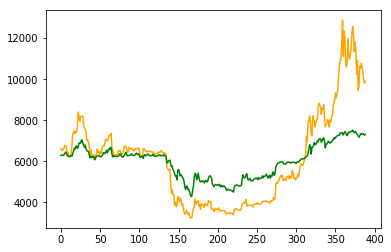

In [52]:
def main():    
    # ------------------------------------------ PREPROCESSING ----------------------------------------------
    raw_price_data = fetch_latest_BTC_JSON()
#     raw_price_data = fetch_btc_prices()
    data_df = parse_alphaV_JSON(raw_data=raw_price_data)
    #data_df = data_df.iloc[::-1]
    
    print(data_df)
    
    prices = np.array(data_df['4a. close (USD)'].tolist())
    print(prices)
    
    original_volume = data_df['5. volume'].values
    min_volume = np.min(data_df['5. volume'].values)
    max_volume = np.max(data_df['5. volume'].values)
    
    print('---------------- original volume -----------------------')
    print(original_volume)
    print('---------------- original volume -----------------------')
    
    print(min_volume)
    print(max_volume)
    
    data_df_temp = data_df.drop(labels=['1a. open (USD)','1b. open (USD)','2b. high (USD)','3b. low (USD)','4a. close (USD)','4b. close (USD)','6. market cap (USD)'],axis=1) # ,'2a. high (USD)','3a. low (USD)'
    minmax_2 = preprocessing.MinMaxScaler()
    print('------slattt-----')
    print(data_df_temp)
    data_df_temp = pd.DataFrame(minmax_2.fit_transform(data_df_temp), columns=data_df_temp.columns)
    
    # -- Normalize the Data --
    min_max_scaler = preprocessing.MinMaxScaler()
    data_df = pd.DataFrame(min_max_scaler.fit_transform(data_df), columns=data_df.columns)
    # print(data_df)
    data_df = table_edit(data_df)
    y_train = np.array(data_df['4a. close (USD)'].tolist())
    data_df = data_df.drop(labels=['4a. close (USD)'],axis=1)
    
    data_df = data_df.drop(labels=['1a. open (USD)','6. market cap (USD)'],axis=1) # ,'2a. high (USD)','3a. low (USD)'
    print('---new---')
    print(data_df)

#     vmas = VMA_calculation(prices=data_df['5. volume'].values)
    
#     #print(vmas)
#     #print(un_normalize(norm_val=vmas,min_val=min_volume,max_val=max_volume,typelist=True))
    
#     x_train,y_train,x_test,y_test,train_dataloader,test_dataloader = vol_dataset_prep(vmas,data_df['5. volume'].values,original_volume)
#     vol_predictor = NumberRegression_MLP()
#     model,loss_func,_,_ = vol_train(vol_predictor, train_dataloader)
#     test_loss,accuracy,predictions = vol_test(vol_predictor,loss_func,test_dataloader,min_volume,max_volume)
#     vol_prediction_visualization(predictions,y_test,min_volume,max_volume)
#     #print(data_df)
#     test = data_df['5. volume'].values
#     print(test)
#     volume_visualization(test)

    model = MLP(3)
    losses, test_data_loader, loss_func, model, min_price, max_price, test_prices = train(model, data_df.values,y_train,prices)
    loss_visualize(losses)
    _, _, all_unnormed_outputs = validation_test(test_dataloader=test_data_loader,criterion=loss_func, model=model, norm_min=min_price, norm_max=max_price)
    
    prediction_visualization(minimum_price=min_price,maximum_price=max_price,close_prices=test_prices,model_predictions=all_unnormed_outputs)
    return minmax_2,model,min_price,max_price

min_max_scaler,price_model,min_price,max_price = main()

## Inference testing

In [53]:
def inference(value, normalize_method, model,minimum_price,maximum_price):
    value = np.array(value).reshape(1,-1)
    # -- Normalize the value --
    value = torch.tensor(normalize_method.transform(value)).float()
    output = model(value)
    output_unnorm = un_normalize(norm_val=output.detach(),min_val=minimum_price,max_val=maximum_price)
    return output_unnorm

def main(normalizer,model,minimum_price,maximum_price):
    output = inference(value=[ 9600,10000,vol[-1]],
                       normalize_method=normalizer,
                       model=model,
                       minimum_price=minimum_price,
                       maximum_price=maximum_price
                      )
    print('BTC prediction: ', output)
    
    
main(normalizer=min_max_scaler,model=price_model,minimum_price=min_price,maximum_price=max_price)

BTC prediction:  tensor([[7345.8638]])
